# Lab 3: PID control of 4th order plant

The plant's input-output dynamics are represented by:
$$Y(s)= \frac{R_{of1}+R_{of2}}{R_{of1}}\left[
\left( \frac{R_{om1}}{R_{om1}+R_{om2}}\right)\frac{\omega_{n1}^2}{s^2 + 2\zeta_1 \omega_{n1} s + \omega_{n1}^2} + \left( \frac{R_{om2}}{R_{om1}+R_{om2}}\right)\frac{\omega_{n2}^2}{s^2 + 2\zeta_2 \omega_{n2} s + \omega_{n2}^2}\right]
\left[U(s) + D(s) \right]$$
The system's two inputs are the control input $u$ and the disturbance input $d$. The outputs are the output voltage $y$ and its derivative, $\dot y$. Design software by S. B. Fuller 2023.04, based on a Matlab version by M. C. Berg 2017.05.

In [16]:
import numpy as np # numerical arrays
import matplotlib.pyplot as plt # plotting
%config InlineBackend.figure_format='retina' # high-res plots
import control.matlab as ctm # matlab layer for control systems library
import control as ct # use regular control library for a few things 
ct.set_defaults('statesp', latex_repr_type='separate') # show ABCD matrices

## state-space plant model

Natural frequency of low-frequency vibration mode = 0.9825127984059134 Hz
Damping ratio of low-frequency vibration mode = 0.09111805529092465
Natural frequency of high-frequency vibration mode = 20.527664581044217 Hz
Damping ratio of high-frequency vibration mode = 0.05223654379696277
DC gain of plant u input = 1.01


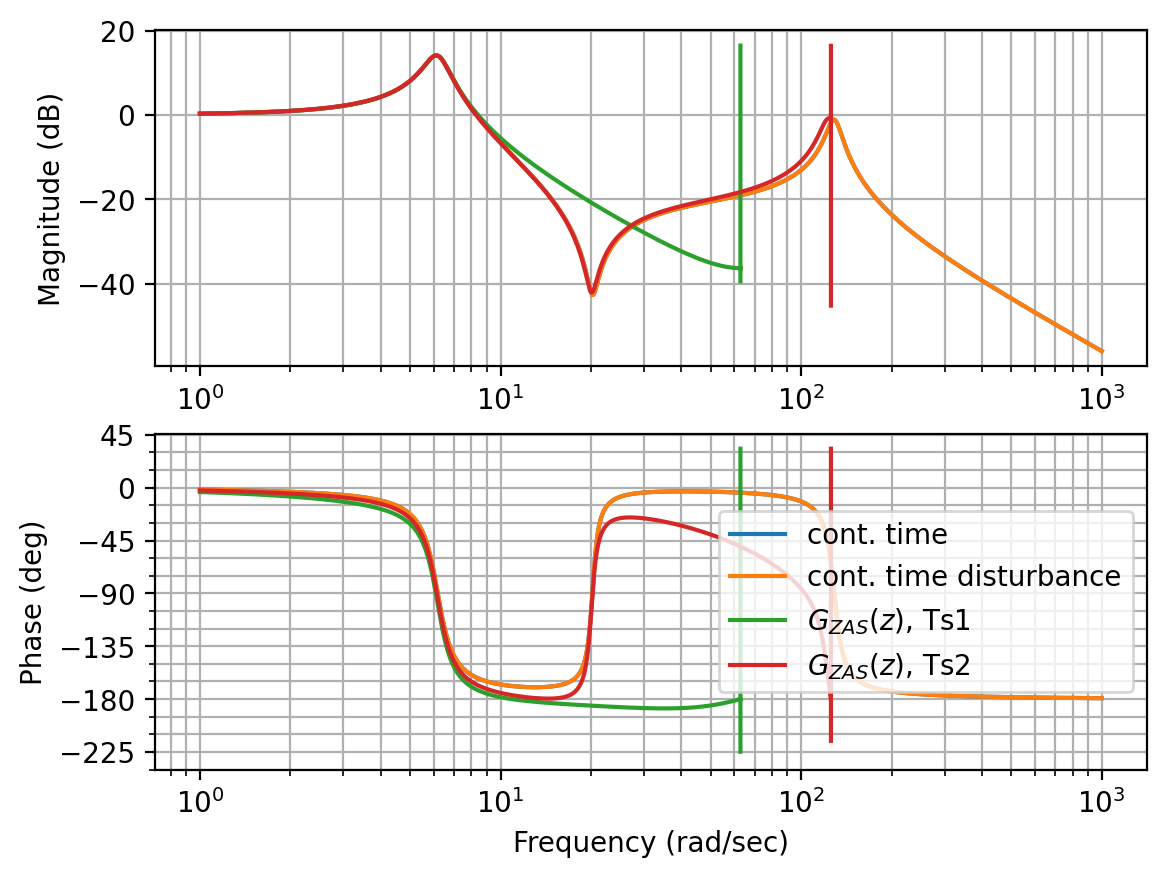

In [17]:
# low-frequency mode
R1 = 160e3 # ohms. "e3" is shorthand for the exponent of ten and means "times 10^3"
R2 = 200e3 # ohms
C1 = 10e-6 # farads
C2 = 0.082e-6 # farads
tau1 = R1 * C1
tau2 = R2 * C2
tau3 = R1 * C2
omegan1 = 1/np.sqrt(tau1 * tau2)
print('Natural frequency of low-frequency vibration mode =', omegan1/(2*np.pi), 'Hz')
zeta1 = (tau2 + tau3) * omegan1/2
print('Damping ratio of low-frequency vibration mode =', zeta1)

# high-frequency mode
R3 = 68e3
R4 = 13e3
C3 = 6.8e-6
C4 = 0.01e-6
tau1 = R3 * C3
tau2 = R4 * C4
tau3 = R3 * C4
omegan2 = 1/np.sqrt(tau1 * tau2);
print('Natural frequency of high-frequency vibration mode =',omegan2/(2*np.pi), 'Hz')
zeta2 = (tau2 + tau3) * omegan2 / 2
print('Damping ratio of high-frequency vibration mode =',zeta2)

# weighting factors
Rof1 = 10e3
Rof2 = 100
Rom1 = 10e3
Rom2 = 1e3 
K1 = (Rof1 + Rof2)/Rof1*Rom1/(Rom1+Rom2) # gain of first mode
K2 = (Rof1 + Rof2)/Rof1*Rom2/(Rom1+Rom2) # gain of second mode

AA = np.array(
    [[          0,                1,            0,                0],  # x1
     [-omegan1**2, -2*zeta1*omegan1,            0,                0],  # d(x1)/dt
     [          0,                0,            0,                1],  # x2
     [          0,                0,  -omegan2**2, -2*zeta2*omegan2]]) # d(x2)/dt
BBu = np.array(
    [[         0], 
     [omegan1**2],
     [         0],            
     [omegan2**2]])
BBd = np.array(
    [[         0], 
     [omegan1**2],
     [         0],            
     [omegan2**2]])
BB = np.hstack([BBu,  BBd])
CC = np.array(
    [[K1,      0,       K2,        0],                  # y    
     [0,       K1,       0,       K2]])                 # dy/dt 
DD = np.array(
    [[0,   0],
     [0,   0]])
plant = ctm.ss(AA, BB, CC, DD)
dcgain = ctm.dcgain(plant[0,0])
print('DC gain of plant u input =', dcgain)
Kff = 1/dcgain

Ts1 = 50/1000 # 50 msec
Ts2 = 25/1000 # 25 msec
plantdisc1 = ctm.c2d(plant[0,0], Ts1, 'zoh')
plantdisc2 = ctm.c2d(plant[0,0], Ts2, 'zoh');
ctm.bode(plant[0,0], label='cont. time')
ctm.bode(plant[0,1], label='cont. time disturbance')
ctm.bode(plantdisc1, label='$G_{ZAS}(z)$, Ts1')
ctm.bode(plantdisc2, label='$G_{ZAS}(z)$, Ts2')
plt.legend();

function to plot lines of constant damping and settle time:

In [18]:
def plot_constant_lines_z(zeta, omegan, T=1, c=None, plot_omegan=False):
    """plot lines of constant damping ratio (zeta), time constant 
    (1/zeta*omegan) and omegan on the z-plane"""
    nyquist_freq = np.pi/T
    freqs = np.linspace(-nyquist_freq, nyquist_freq, 201, endpoint=True)
    # constant time constant is a vertical line in s-plane at -zeta*omegan
    timeconstant_line_s = -zeta*omegan*np.ones_like(freqs) + 1j*freqs
    timeconstant_line_z = np.exp(timeconstant_line_s*T)
    plt.plot(timeconstant_line_z.real, timeconstant_line_z.imag,
             '--', c=c, label=f'$\zeta\omega_n$={zeta*omegan:.3f}')
    # constant damping ratio zeta is a radial line from origin in splane
    damping_line_splane = -abs(freqs)/np.tan(np.arccos(zeta)) + 1j*freqs 
    damping_line_zplane = np.exp(damping_line_splane*T)
    plt.plot(damping_line_zplane.real, damping_line_zplane.imag,'-', c=c, 
            label=f'$\zeta$={zeta:.3f}')
    if plot_omegan: # circle centered at origin in s-plane
        angles = np.linspace(np.pi/2, 3./2*np.pi, 31, endpoint=True)
        omegan_line_s = omegan*np.exp(1j*angles)
        omegan_line_z = np.exp(omegan_line_s*T)
        plt.plot(omegan_line_z.real, omegan_line_z.imag, 
                c=c, ls='-.', label=f'$\omega_n$={omegan:.3f}')

In [19]:
# create systems used for interconnections
C_ff = ctm.tf2ss(Kff, 1, inputs='r', outputs='uff') 
e_summer = ct.summing_junction(['r', '-y'], 'e')
u_summer = ct.summing_junction(['uf', 'uff','-ub', 'd'], 'u')

## Controller design

The following cell allows you to iteratively explore how adding or subtracting an amount $\delta K$ to one of the PID gains $K_p$, $K_i$, and $K_d$ affect the step and frequency of the system so that its performance can be tuned. To use, perform the following steps, editing *only* the elements surrounded by `###`: 

1. Choose the starting point for your gain values, which gain to vary, direction, and input signal. 
2. Run the cell. A figure appears showing a bode plot and step response for $\delta K=0.1$. The top right figure shows the root locus as $\delta K$ varies from 0 to $\infty$. Click on a branch of the root locus plot to try a different $\delta K$; the associated $\delta K$ is printed below the cell and the step response and bode plots are updated. 
    * remark: you can zoom in using the magnifying glass; you must click the magnifying glass again to be able to choose a gain on the root locus plot again. 
3. Once you have found a suitable gain change $\delta K$, its value appers as `gain` on the bottom of the printout beneath the cell. *Add or subtract it* to the gain you chose above and return to step 1 for further iteration.  
4. Copy your chosen gains including your new gain into the subsequent cell to simulate the full sampled-data system.

    **Example**: to examine the effect of varying Kp starting from an intial
    value of 10, use `gain = 'P'` and `Kp0 = 10`. If a $\delta K$
    value of 5 is found to give satisfactory performance, then use `Kp0 = 15`
    on the next iteration. 
    
### ***for online notebook users***
If you are using an online notebook like Google colab, you cannot use live, clickable plots. Instead, comment out the first line on the next cell to use inline plots, and you can repeatedly run this cell with different values $\delta K$ by setting the value of the `initial_gain` argument in `sisotool` at the bottom of this cell to your desired $\delta K$.

In [98]:
# comment out the following line if you are using an online notebook like colab (see cell above)
%matplotlib

### choose between plantdisc1 or plantdisc2, which have different sampling times
plantdisc = ctm.ss(plantdisc1, inputs='u', outputs='y')
# starting point gains
Kp0 = 0.
Ki0 = 0.2
Kd0 = 0.25
# choose which gain to vary, choose one of: 'P', 'I', or 'D' 
gain = 'p'
# pick direction to vary the gain 
sign = 1
# pick input, one of 'r' for reference or 'd' for disturbance
input_signal = 'r'
###

# see lecture slides for explanation for the following construction
Ts = plantdisc.dt
prop  = ctm.tf2ss(1, 1,                 inputs='e', outputs='prop_e')
integ = ctm.tf([Ts, 0], [1, -1], Ts,    inputs='e', outputs='int_e')
deriv = ctm.tf([1, -1], [Ts, 0], Ts,    inputs='y', outputs='deriv_y')
Kpgain = ctm.tf2ss(Kp0, 1,              inputs='prop_e',  outputs='uf')
Kigain = ctm.tf2ss(Ki0, 1,              inputs='int_e',   outputs='uf')
Kdgain = ctm.tf2ss(Kd0, 1,              inputs='deriv_y', outputs='ub')
if gain == 'P' or gain == 'p': 
    Kpgain = ctm.ss([],[],[],[[0, 1], [-sign, Kp0]], 
                   inputs=['input', 'prop_e'], outputs=['output', 'uf'])
elif gain == 'I' or gain == 'i':
    Kigain = ctm.ss([],[],[],[[0, 1], [-sign, Ki0]], 
                   inputs=['input', 'int_e'], outputs=['output', 'uf'])
elif gain == 'D' or gain == 'd':
    Kdgain = ctm.ss([],[],[],[[0, 1], [-sign, Kd0+1e-5]], 
                   inputs=['input', 'deriv_y'], outputs=['output', 'ub'])
else: 
    raise ValueError(gain_selection + ' gain not recognized.')

loop = ct.interconnect((plantdisc, Kpgain, Kigain, Kdgain, 
                        prop, integ, deriv, C_ff, e_summer, u_summer), 
                    inputs=['input', input_signal], outputs=['output', 'y'])

ctm.sisotool(loop, initial_gain=0.1)
plt.sca(plt.gcf().get_axes()[1]) # switch to root locus plot
plot_constant_lines_z(.7797, 5.13, Ts)
plt.axis((-1,1,-1,1));

Using matplotlib backend: TkAgg


ValueError: Systems have incompatible timebases

## simulate sampled-data system (digital+analog):

In [21]:
def sampled_data_system(sysd, simulation_dt): 
    """Create a (discrete-time, non-linear) sampled-data system. 
    
    The returned system models the behavior of a sampled-data system 
    `sysd`, such as a controller consisting of a sampler and a 
    digital-to-analog converter. The returned system is discrete-time, 
    with a timebase `simulation_dt` smaller than or equal to the 
    sampling interval `sysd.dt`. Using a small `simulation_dt` will 
    insure that continuous-time dynamics of the interconnected 
    systems are accurately simulated. The system returned by this 
    function must be interconnected with other systems that also 
    have a timebase equal to `simulation_dt`. `sysd.dt` must be greater 
    than or equal to `simulation_dt`, and an integral multiple of it. 
    Connect to a continuous-time system such as a plant `P` by first 
    converting `P` to a discrete-time system using e.g. 
    `P_sim = P.sample(simulation_dt)`. To implement a sampled static 
    gain (e.g. a proportional control law), insure that `sysd` has at 
    least one state, even if it has no effect on the output. For 
    example, for a gain `Kp`, use `sysd = ct.ss(0,0,0,Kp,Ts)`. 
    """
    assert ct.isdtime(sysd, True), "sysd must be discrete-time"
    sysd = ct.ss(sysd) # convert to state-space if not already
    nsteps = int(round(sysd.dt / simulation_dt))
    assert np.isclose(nsteps, sysd.dt/simulation_dt), \
        "simulation_dt must be an integral multiple of sysd.dt"
    st = 0
    y = np.zeros((sysd.noutputs, 1))
    def updatefunction(t, x, u, params): 
        nonlocal st
        if st == 0: # is it time to sample?
            x = sysd._rhs(t, x, u)
        st += 1
        if st == nsteps:
            st = 0
        return x
    def outputfunction(t, x, u, params):
        nonlocal y
        if st == 0: # is it time to sample?
            y = sysd._out(t, x, u) 
        return y
    return ct.ss(updatefunction, outputfunction, dt=simulation_dt, 
                 name=sysd.name, inputs=sysd.input_labels, 
                 outputs=sysd.output_labels, states=sysd.state_labels)

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (9, 3)=sys[104].d
  warn(msg)
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\iosys.py:1503: UserWarning: Unused input(s) in InterconnectedSystem: (7, 0)=sys[7164].r; (8, 0)=sys[103].r
  warn(msg)


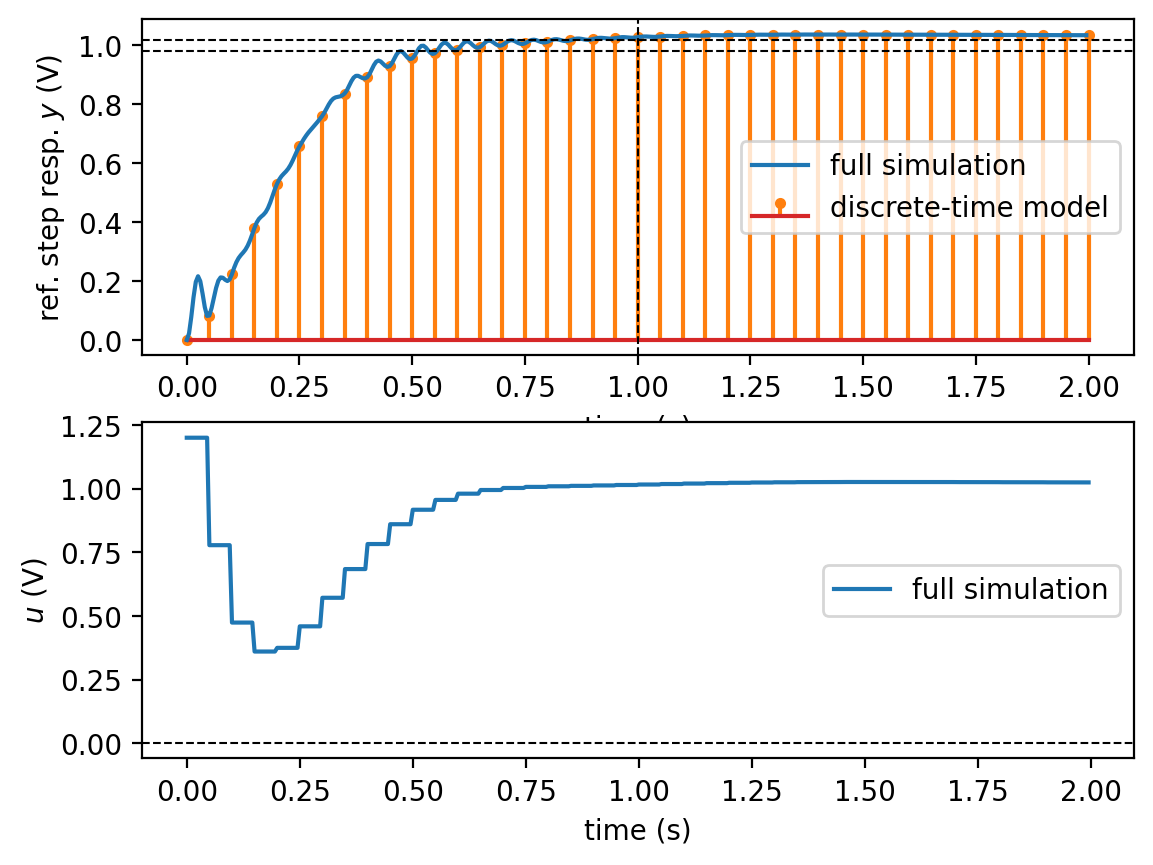

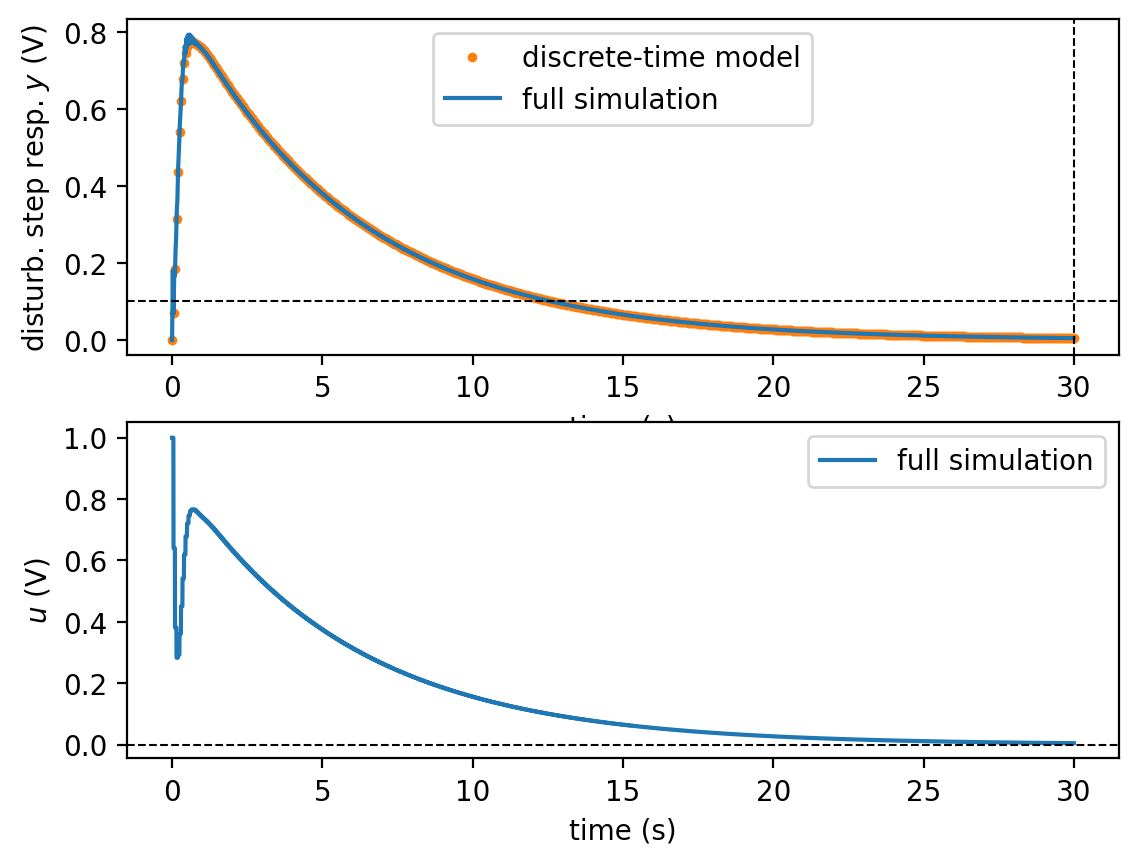

In [132]:
# back to in-line plots:
%matplotlib inline 

### choose between plantdisc1 or plantdisc2 (different sampling times)
plantdisc = ctm.ss(plantdisc1, inputs='u', outputs='y')
# final gains
Kp = 0.2
Ki = 0.2
Kd = 0.25
###

# first simulate discrete-time model from GZAS model of plant, for stem plot
Ts = plantdisc.dt
# the folowing two have zero A and B matrices to insure that it has states so 
# that sampling works correctly, see sampled_data_system function above
C_ff = ctm.ss(0, 0, 0, Kff, Ts,         inputs='r', outputs='uff') 
prop  = ctm.ss(0, 0, 0, 1, Ts,          inputs='e', outputs='prop_e')
integ = ctm.tf([Ts, 0], [1, -1], Ts,    inputs='e', outputs='int_e')
deriv = ctm.tf([1, -1], [Ts, 0], Ts,    inputs='y', outputs='deriv_y')
Kpgain = ctm.tf2ss(Kp, 1,              inputs='prop_e',  outputs='uf')
Kigain = ctm.tf2ss(Ki, 1,              inputs='int_e',   outputs='uf')
Kdgain = ctm.tf2ss(Kd, 1,              inputs='deriv_y', outputs='ub')
# r to y
Gyr_discrete = ct.interconnect((plantdisc, Kpgain, Kigain, Kdgain, 
                                prop, integ, deriv, C_ff, e_summer, u_summer), 
                               inputs='r', outputs='y')
# d to y
Gyd_discrete = ct.interconnect((plantdisc, Kpgain, Kigain, Kdgain, 
                                prop, integ, deriv, C_ff, e_summer, u_summer), 
                               inputs='d', outputs='y')

plt.figure(1)
plt.subplot(2,1,1)
y, t = ctm.step(Gyr_discrete, T=2)
plt.stem(t, y, 'C1', markerfmt='C1.', label='discrete-time model')

plt.figure(2)
plt.subplot(2,1,1)
y, t = ctm.step(Gyd_discrete, T=30)
plt.plot(t, y, 'C1.', markersize=5, label='discrete-time model')

# simulate full sampled-data system by simulating with a much shorter dt. 
simulation_dt = 0.005

# constituent parts
# note: pure gains Kpgain, Kigain, and Kdgain don't need to be converted
prop_sim = sampled_data_system(prop, simulation_dt)
integ_sim = sampled_data_system(integ, simulation_dt)
deriv_sim = sampled_data_system(deriv, simulation_dt)
C_ff_sim = sampled_data_system(C_ff, simulation_dt)
plant_sim = ctm.ss(ctm.c2d(plant[0,0], simulation_dt, 'zoh'), inputs='u', outputs='y')

# closed-loop r to y and u 
Gr_sim = ct.interconnect((plant_sim, Kpgain, Kigain, Kdgain, 
                           prop_sim, integ_sim, deriv_sim, 
                           C_ff_sim, e_summer, u_summer), 
                          inputs='r', outputs=['y', 'u'])
# closed-loop d to y and u 
Gd_sim = ct.interconnect((plant_sim, Kpgain, Kigain, Kdgain, 
                           prop_sim, integ_sim, deriv_sim, 
                           C_ff_sim, e_summer, u_summer), 
                          inputs='d', outputs=['y', 'u'])

# simulate 
plt.figure(1)
plt.subplot(2,1,1)
time_sim = np.arange(0, 2, simulation_dt)
input_sim = np.ones_like(time_sim) 
t, y  = ct.input_output_response(Gr_sim, time_sim, input_sim)
plt.plot(t, y[0], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('ref. step resp. $y$ (V)')
plt.legend()
plt.axhline(1.02, c='k', linestyle="--", linewidth=0.75)
plt.axhline(.98, c='k', linestyle="--", linewidth=0.75)
plt.axvline(1, c='k', linestyle="--", linewidth=0.75)

plt.subplot(2,1,2)
plt.plot(t, y[1], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('$u$ (V)')
plt.axhline(0, c='k', linestyle="--", linewidth=0.75)
plt.legend()

plt.figure(2)
time_sim = np.arange(0, 30, simulation_dt)
input_sim = np.ones_like(time_sim)
t2, y2 = ct.input_output_response(Gd_sim, time_sim, input_sim)
plt.subplot(2,1,1)
plt.plot(t2, y2[0], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('disturb. step resp. $y$ (V)')
plt.axhline(.1, c='k', linestyle="--", linewidth=0.75)
plt.axvline(30, c='k', linestyle="--", linewidth=0.75)
plt.legend()

plt.subplot(2,1,2)
plt.plot(t2, y2[1], label='full simulation')
plt.xlabel('time (s)')
plt.ylabel('$u$ (V)')
plt.axhline(0, c='k', linestyle="--", linewidth=0.75)
plt.legend();

c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\lti.py:122: RuntimeWarning: divide by zero encountered in log
  splane_poles = np.log(poles.astype(complex))/self.dt
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\lti.py:122: RuntimeWarning: invalid value encountered in divide
  splane_poles = np.log(poles.astype(complex))/self.dt
c:\Users\YENPANG_HUANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\lti.py:126: RuntimeWarning: invalid value encountered in divide
  Z = -real(splane_poles)/wn


_____Eigenvalue______ Damping___ Frequency_
         0                     1         -0
    0.9958                     1    -0.9958
    0.9752   +0.1644j    0.06645      6.695
    0.9752   -0.1644j    0.06645      6.695
   -0.8595  +0.06371j    0.04839      122.8
   -0.8595  -0.06371j    0.04839      122.8
         0                     1         -0
         0                     1         -0


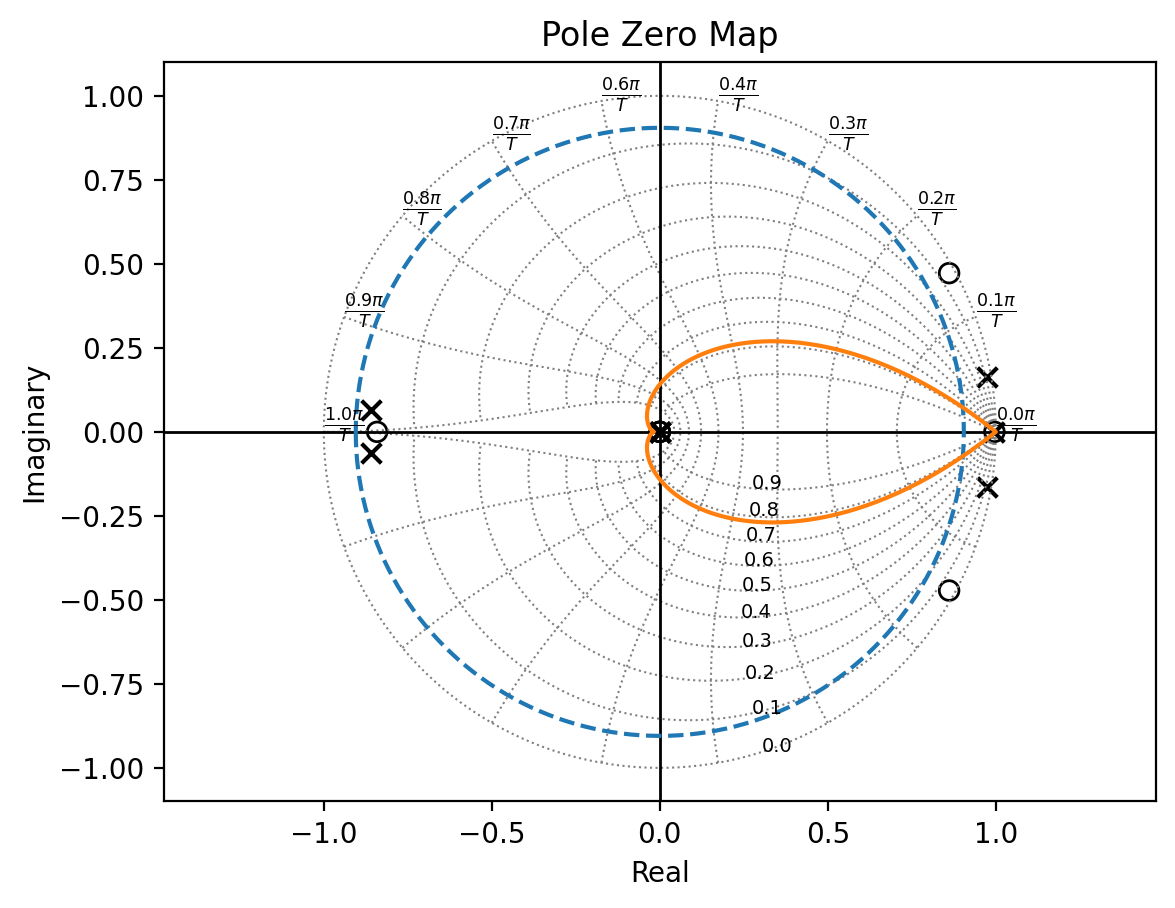

In [107]:
ctm.pzmap(Gyr_discrete, grid=True)
plot_constant_lines_z(.7797, 5.13, Ts)
ctm.damp(Gyr_discrete);
# plt.savefig('pzmap1.jpg')
# plt.savefig('pzmap_dsr.jpg')
# plt.savefig('pzmap_dsr_no_d')

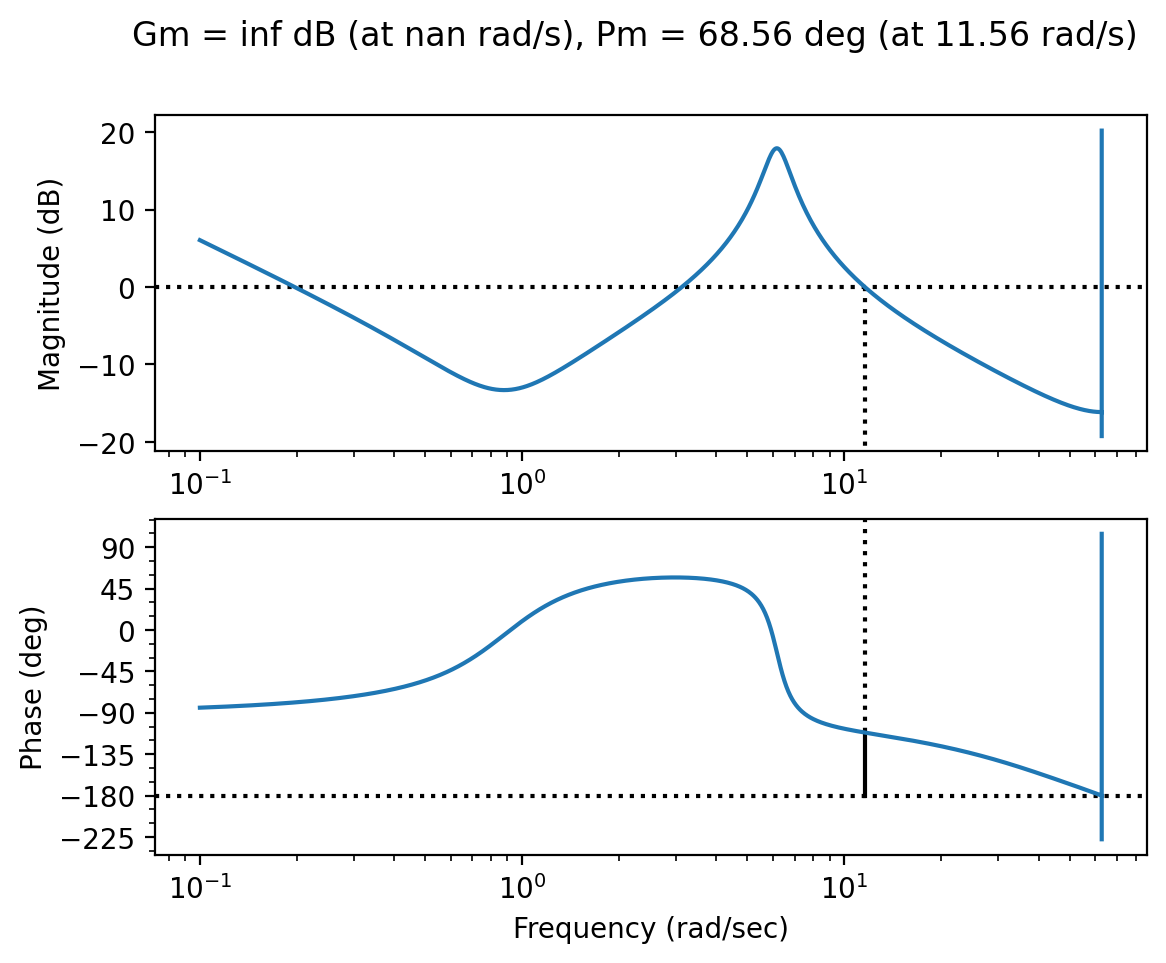

In [123]:
loopdisc = (Kp + Ki * integ + Kd * deriv) * plantdisc
ctm.bode(loopdisc, margins=True);
# plt.savefig('bode1.jpg')

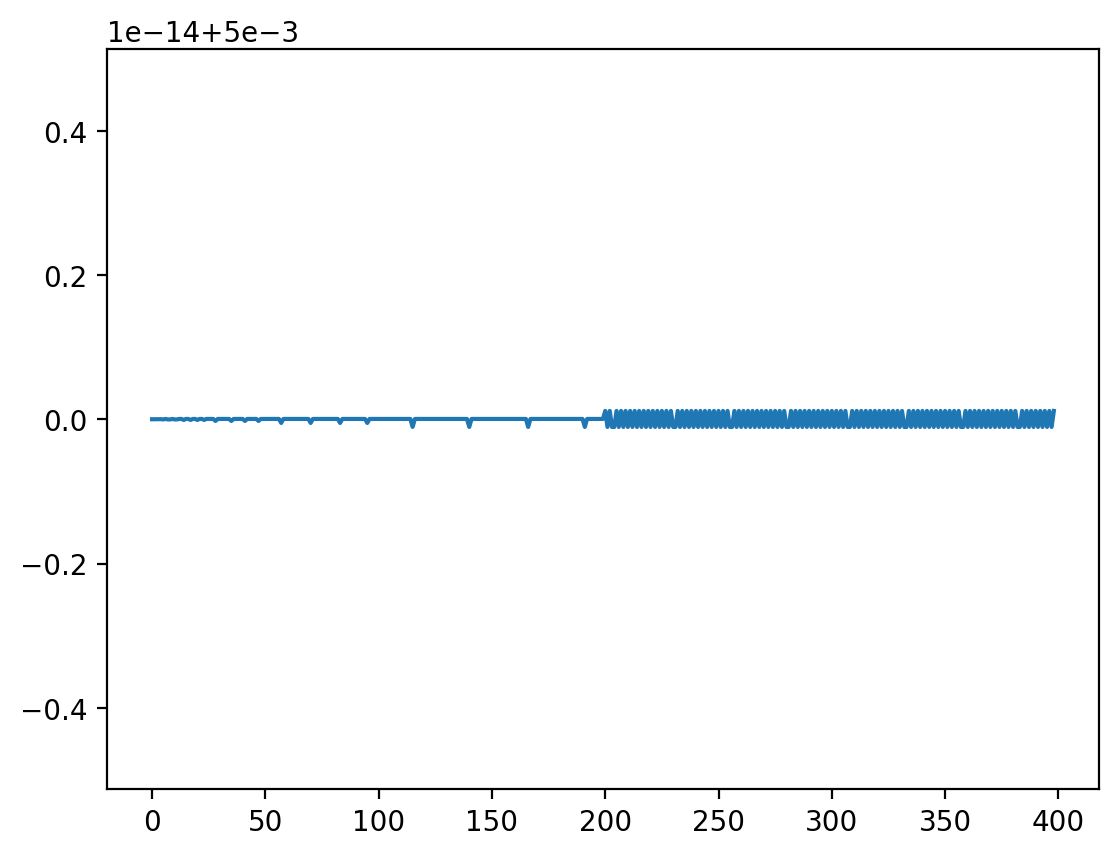

In [133]:
plt.plot(abs(t[1:] - t[:-1]))

# Hardware code

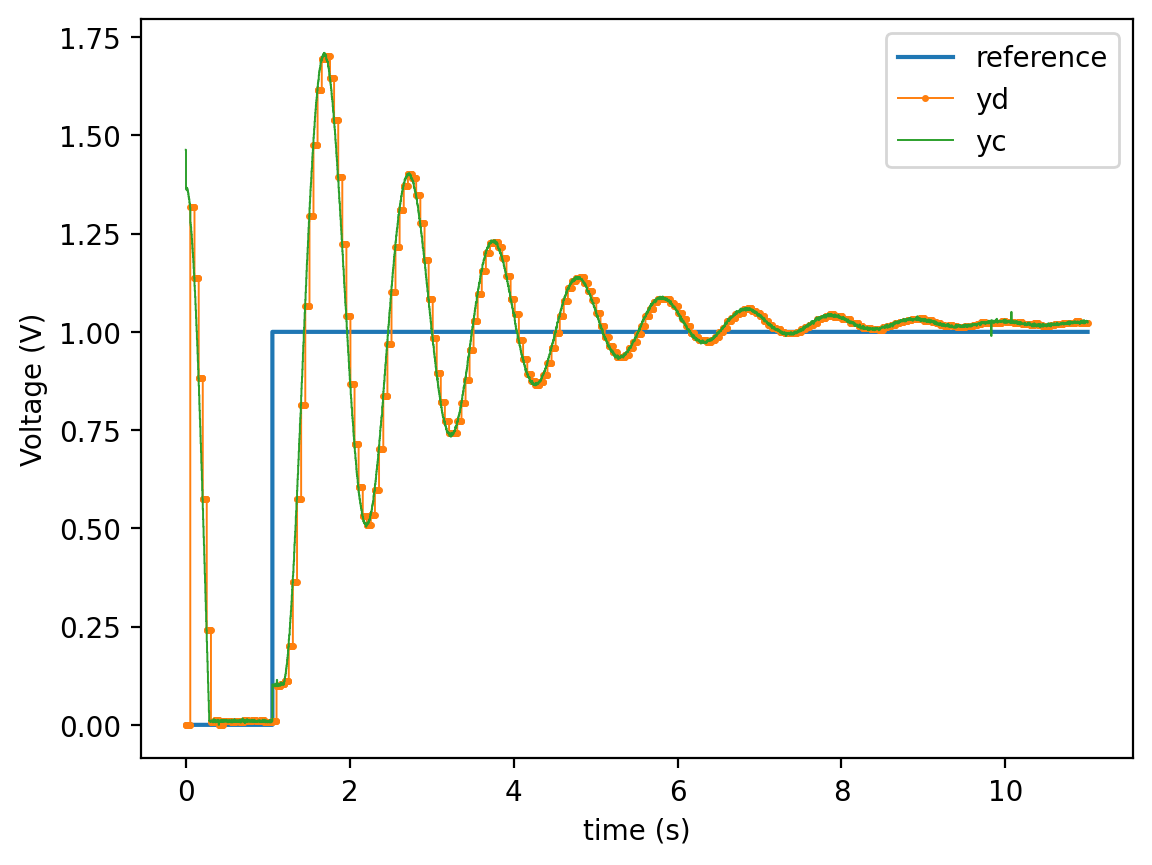

In [139]:
data = np.loadtxt('data1.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, r, label='reference', where='post')
plt.step(time, yd, '.-', markersize=3,
linewidth=0.7, label='yd', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='yc', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
# plt.savefig('origin.jpg') 

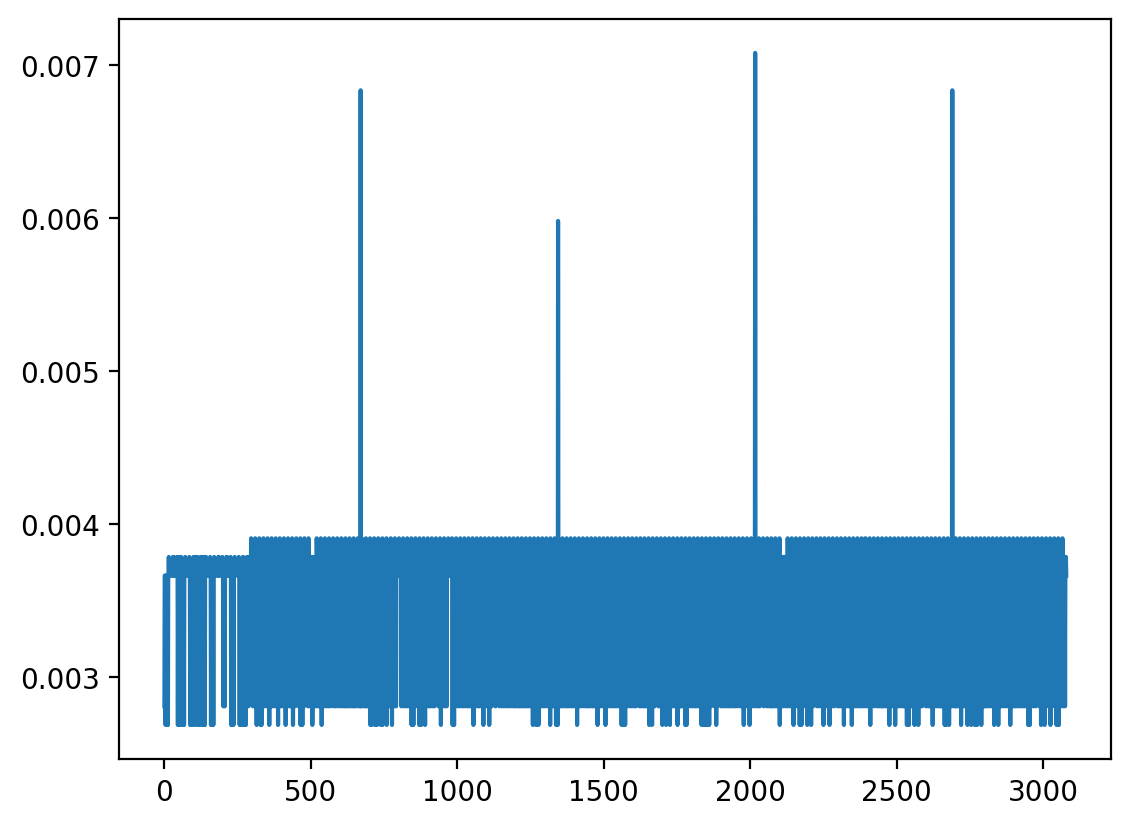

In [141]:
plt.plot(abs(time[1:]-time[:-1]))
plt.savefig('timing.jpg')

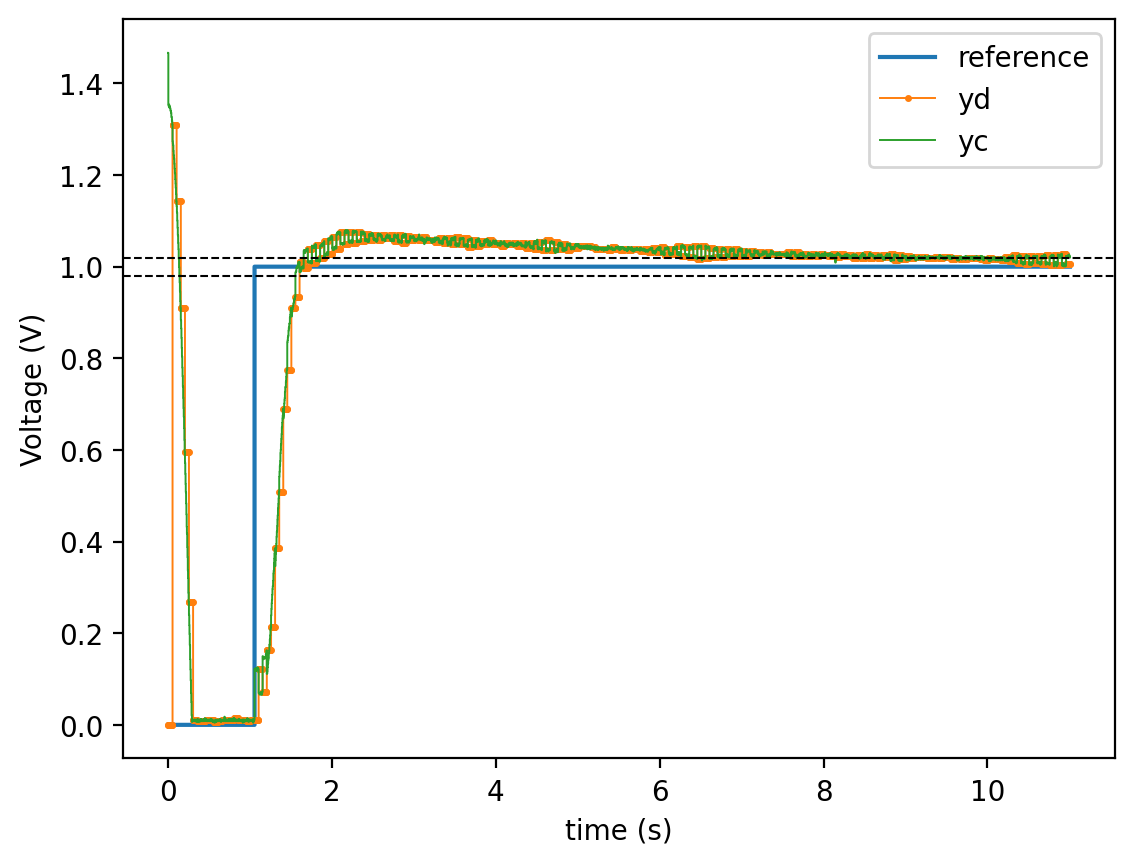

In [76]:
data = np.loadtxt('data2.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, r, label='reference', where='post')
plt.step(time, yd, '.-', markersize=3,
linewidth=0.7, label='yd', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='yc', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
plt.axhline(1.02, c='k', linestyle="--", linewidth=0.75)
plt.axhline(.98, c='k', linestyle="--", linewidth=0.75)
plt.savefig('tunedPID.jpg')

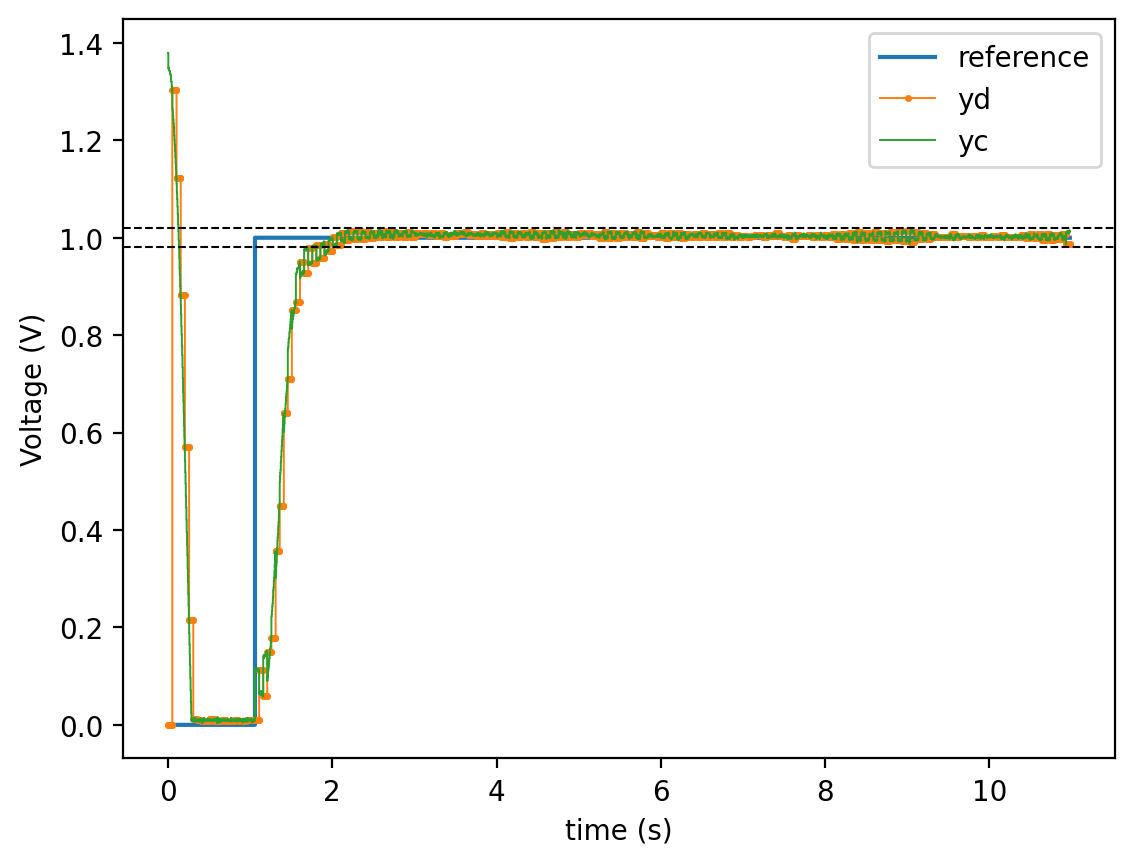

In [138]:
data = np.loadtxt('data3.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, r, label='reference', where='post')
plt.step(time, yd, '.-', markersize=3,
linewidth=0.7, label='yd', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='yc', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
plt.axhline(1.02, c='k', linestyle="--", linewidth=0.75)
plt.axhline(.98, c='k', linestyle="--", linewidth=0.75)
# plt.savefig('tunedPIDandK.jpg')

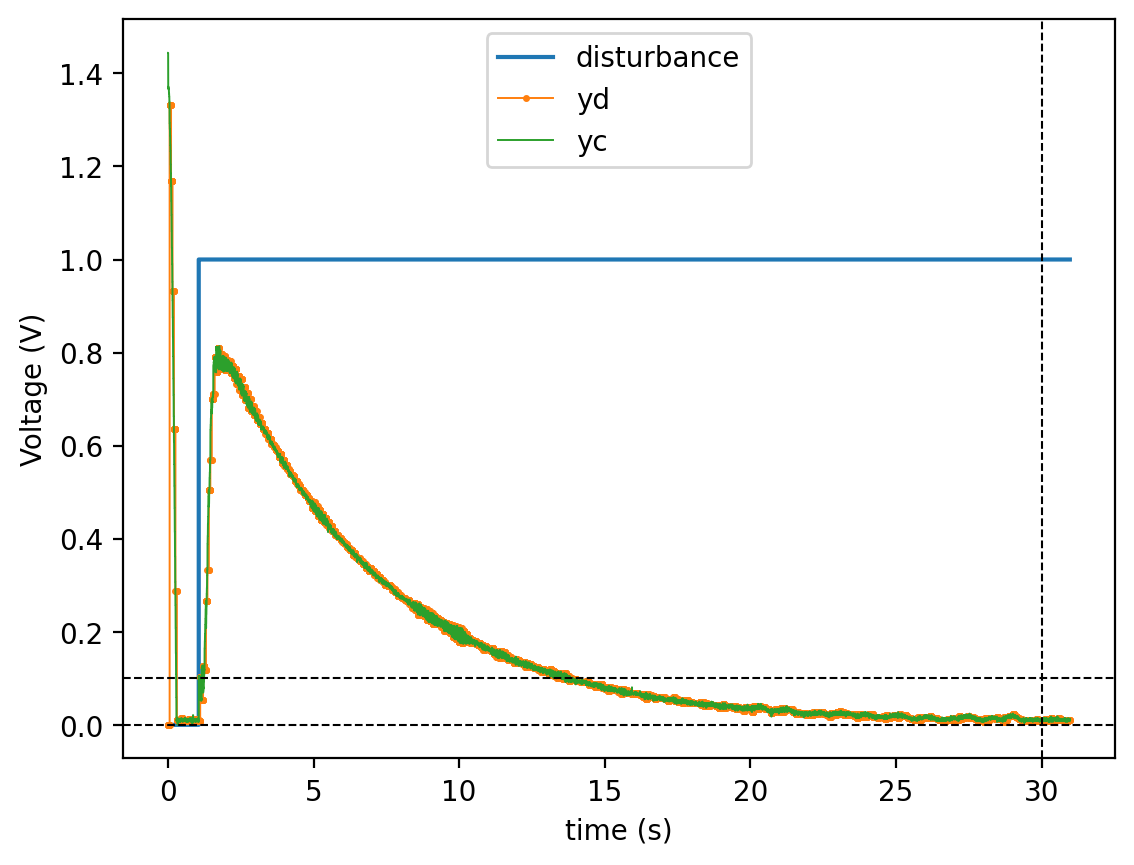

In [79]:
data = np.loadtxt('data4.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, d, label='disturbance', where='post')
plt.step(time, yd, '.-', markersize=3,
linewidth=0.7, label='yd', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='yc', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
plt.axhline(.1, c='k', linestyle="--", linewidth=0.75)
plt.axhline(0, c='k', linestyle="--", linewidth=0.75)
plt.axvline(30, c='k', linestyle="--", linewidth=0.75)
plt.savefig('tunedPID_d.jpg')

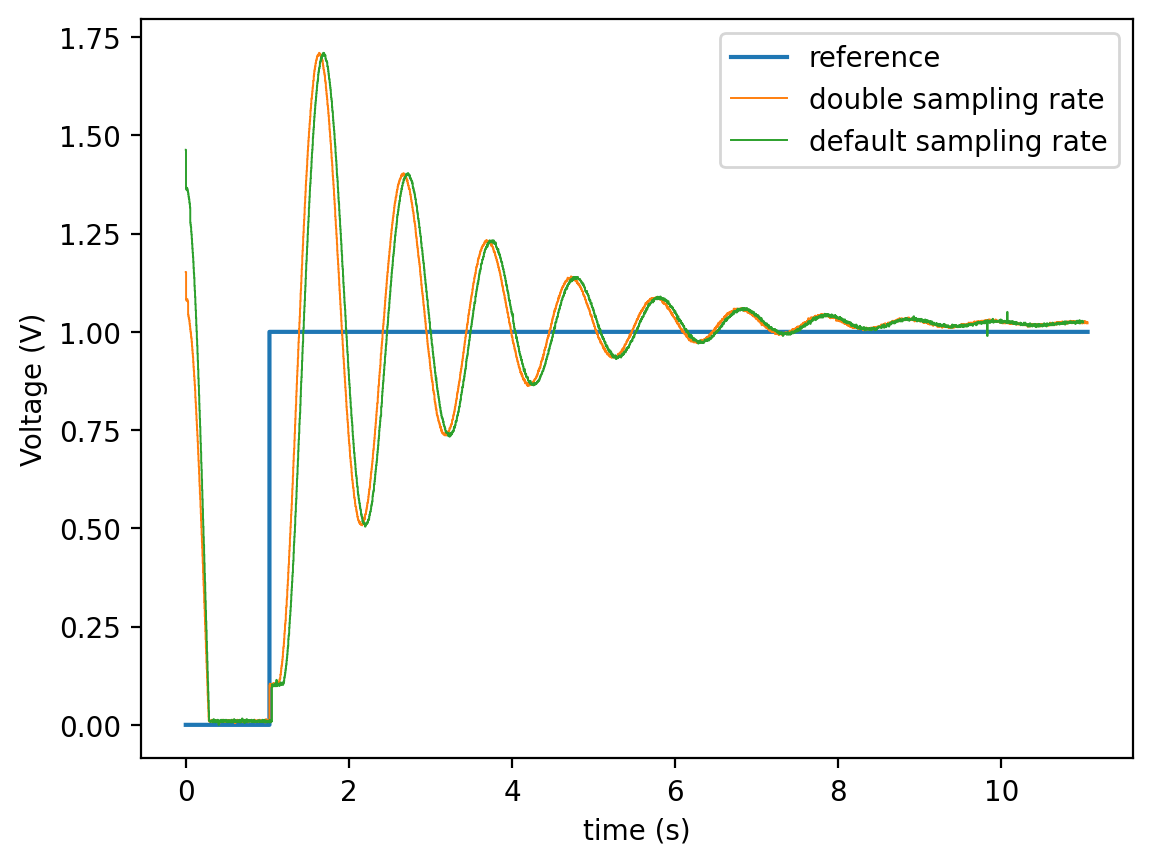

In [103]:
data = np.loadtxt('data5.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, r, label='reference', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='double sampling rate', where='post')

data = np.loadtxt('data1.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='default sampling rate', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
plt.savefig('dsr.jpg')

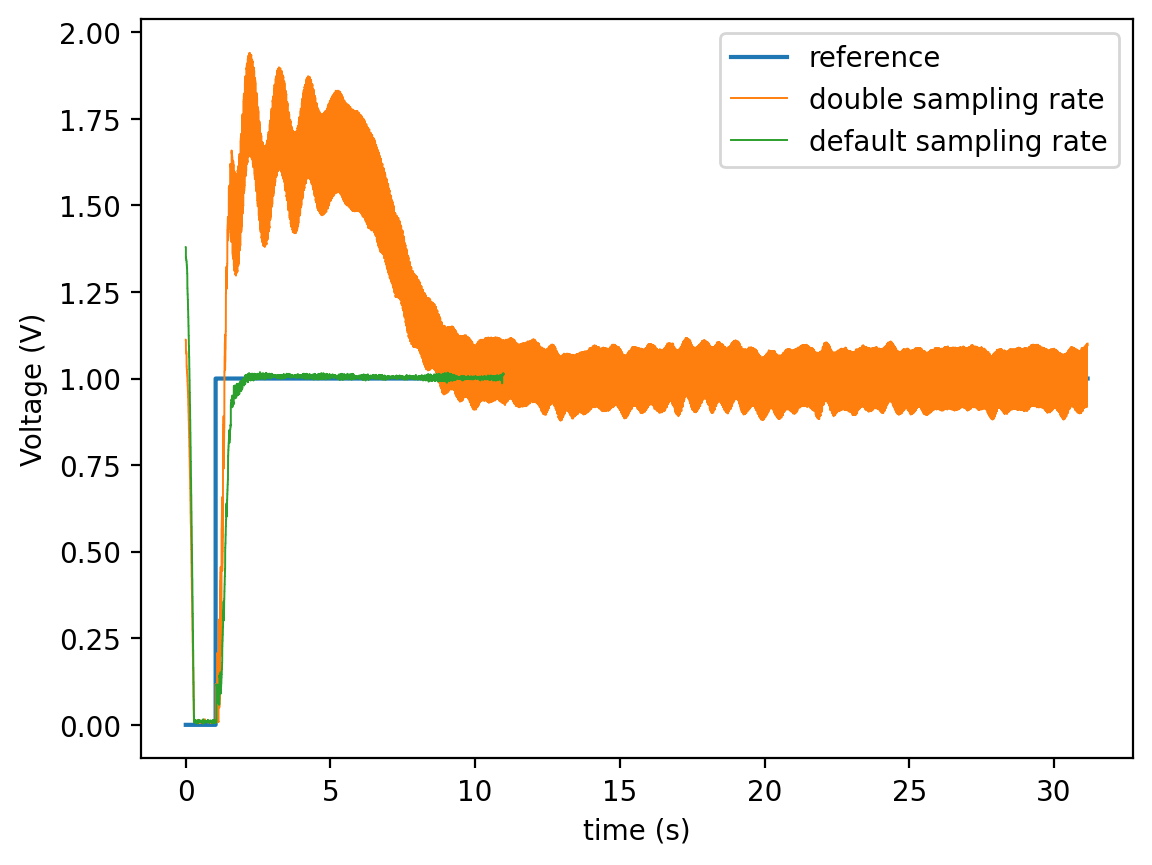

In [104]:
data = np.loadtxt('data6.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.figure()
plt.step(time, r, label='reference', where='post')
plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='double sampling rate', where='post')

data = np.loadtxt('data3.csv', delimiter=',')
time = data[:, 1]/1e9
yc = data[:, 2]
td = data[:, 3]
yd = data[:, 4]
r = data[:, 5]
d = data[:, 6]
u = data[:, 7]
usat = data[:, 8]

plt.step(time, yc, '-', markersize=3,
linewidth=0.7, label='default sampling rate', where='post')
plt.xlabel('time (s)')
plt.ylabel('Voltage (V)')
plt.legend( loc='best')
plt.savefig('dsr_tuned.jpg')